<a href="https://colab.research.google.com/github/TaicirCheikhrouhou/Brain-Tumor-Detection-Transfer-Learning-XAI/blob/main/TransFerLearning_Finetuning_XAI1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports & reproducibility
import os, random, math, joblib, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

random.seed(42)
np.random.seed(42)

# CV/ML imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, confusion_matrix)

from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from imblearn.over_sampling import SMOTE

# Computer vision imports

from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from skimage import exposure




In [ ]:
from google.colab import files

# Upload Kaggle API key
print("Please upload your kaggle.json file:")
uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
  uploaded_filename = fn

# Configure Kaggle API
!mkdir -p ~/.kaggle/
!mv /content/"{uploaded_filename}" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle setup
!kaggle --version

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes
Kaggle API 1.7.4.5


In [ ]:
# Download the dataset from Kaggle
print("Downloading brain MRI images dataset from Kaggle...")
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

from zipfile import ZipFile
file_name = "brain-mri-images-for-brain-tumor-detection.zip"
print(f"Extracting {file_name}...")

with ZipFile(file_name, 'r') as zip_file:
  zip_file.extractall()
  print("Extraction completed.")
  print("Contents of extracted directory:")
  !ls -R /content/brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 3.01GB/s]
Extracting brain-mri-images-for-brain-tumor-detection.zip...
Extraction completed.
Contents of extracted directory:
/content/brain_tumor_dataset:
no  yes

/content/brain_tumor_dataset/no:
'10 no.jpg'  '27 no.jpg'  '42 no.jpg'	 N16.jpg       No14.jpg    'no 8.jpg'
'11 no.jpg'  '28 no.jpg'  '43 no.jpg'	 N17.jpg       No15.jpg    'no 90.jpg'
'12 no.jpg'  '29 no.jpg'   44no.jpg	 N19.JPG       No16.jpg    'no 91.jpeg'
'13 no.jpg'  '2 no.jpeg'  '45 no.jpg'	 N1.JPG        No17.jpg    'no 923.jpg'
'14 no.jpg'  '30 no.jpg'  '46 no.jpg'	 N20.JPG       No18.jpg    'no 92.jpg'
'15 no.jpg'  '31 no.jpg'  '47 no.jpg'	 N21.jpg       No19.jpg    'no 94.jpg'
'17 no.jpg'  '32 no.jpg'  '48 no.jpeg'	 N22.JPG      'no 1.jpg'   'no 95.jpg'
'18 no.jpg'  '33 no.jpg'  '49 no.jpg'	 N26.JPG       No20.jpg    'no 96.j

In [ ]:
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

os.chdir('/content/yes')
X = []
y = []
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img,(224,224))
        X.append(img)
        y.append('Y')
os.chdir('/content/no')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img,(224,224))
        X.append(img)
        y.append('N')
print(y)
%matplotlib inline


  0%|          | 0/155 [00:00<?, ?it/s]

Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y
Y


  0%|          | 0/98 [00:00<?, ?it/s]

['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

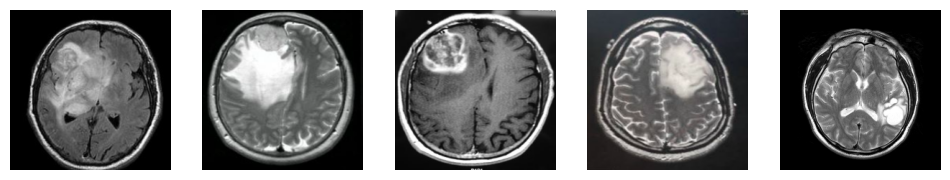

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

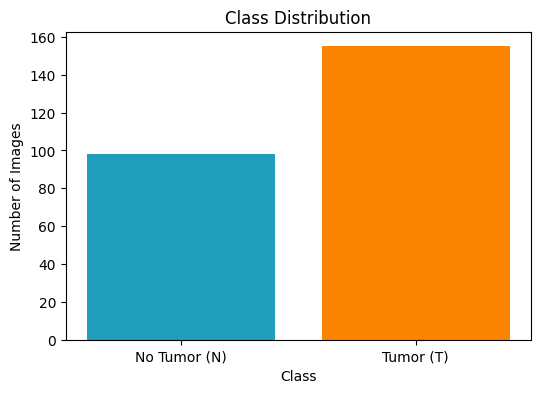

Class distribution:
  N: 98
  Y: 155


In [ ]:
# Analyze class distribution
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(unique_labels, counts, color=['#219ebc', '#fb8500'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(unique_labels, ['No Tumor (N)', 'Tumor (T)'])
plt.show()

print("Class distribution:")
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count}")

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import shutil
from glob import glob
import math

# Paramètres
original_yes = "/content/brain_tumor_dataset/yes"
original_no = "/content/brain_tumor_dataset/no"
augmented_yes = "/content/augmented_yes"
augmented_no = "/content/augmented_no"

final_dir = "/content/data_final"
final_yes = os.path.join(final_dir, "yes")
final_no = os.path.join(final_dir, "no")

os.makedirs(augmented_yes, exist_ok=True)
os.makedirs(augmented_no, exist_ok=True)
os.makedirs(final_yes, exist_ok=True)
os.makedirs(final_no, exist_ok=True)

# Générateur d'augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fonction pour générer exactement le nombre voulu
def generate_images_exact(original_dir, augmented_dir, target_total):
    files = [f for f in os.listdir(original_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    original_count = len(files)
    to_generate_total = target_total - original_count
    print(f"Classe {os.path.basename(original_dir)}: {original_count} images originales, "
          f"on va générer {to_generate_total} images augmentées.")

    per_image = math.ceil(to_generate_total / original_count)
    count = 0

    for file in files:
        img_path = os.path.join(original_dir, file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Génération
        for batch in datagen.flow(x, batch_size=1, save_to_dir=augmented_dir,
                                  save_prefix='aug', save_format='png'):
            count += 1
            if count >= to_generate_total:
                break
        if count >= to_generate_total:
            break
    print(f"✅ Génération terminée : {count} images augmentées enregistrées dans {augmented_dir}\n")

# Génération des images augmentées
generate_images_exact(original_yes, augmented_yes, target_total=5155)
generate_images_exact(original_no, augmented_no, target_total=5155)

# Fusion dans data_final
def merge_images(original_dir, augmented_dir, final_dir):
    for src_dir in [original_dir, augmented_dir]:
        files = glob(os.path.join(src_dir, "*"))
        for f in files:
            shutil.copy(f, final_dir)

merge_images(original_yes, augmented_yes, final_yes)
merge_images(original_no, augmented_no, final_no)

# Comptage final
count_yes = len(os.listdir(final_yes))
count_no = len(os.listdir(final_no))

print("✅ Fusion finale terminée !")
print(f"Total d'images dans la classe 'YES' : {count_yes}")
print(f"Total d'images dans la classe 'NO'  : {count_no}")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Classe yes: 155 images originales, on va générer 5000 images augmentées.
✅ Génération terminée : 5000 images augmentées enregistrées dans /content/augmented_yes

Classe no: 98 images originales, on va générer 5057 images augmentées.
✅ Génération terminée : 5057 images augmentées enregistrées dans /content/augmented_no

✅ Fusion finale terminée !
Total d'images dans la classe 'YES' : 4080
Total d'images dans la classe 'NO'  : 4090


Total images YES: 4080
Total images NO : 4090


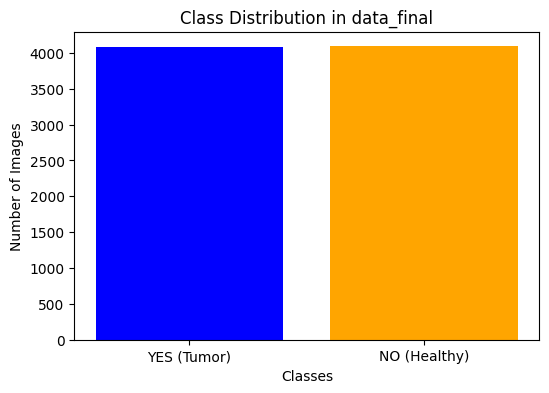

In [ ]:
import os
import matplotlib.pyplot as plt

# Dossiers finaux
final_yes = "/content/data_final/yes"
final_no = "/content/data_final/no"

# Compter le nombre d'images dans chaque classe
yes_count = len([f for f in os.listdir(final_yes) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
no_count = len([f for f in os.listdir(final_no) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"Total images YES: {yes_count}")
print(f"Total images NO : {no_count}")

#histogramme
plt.figure(figsize=(6,4))
plt.bar(['YES (Tumor)', 'NO (Healthy)'], [yes_count, no_count], color=['blue', 'orange'])
plt.title('Class Distribution in data_final')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


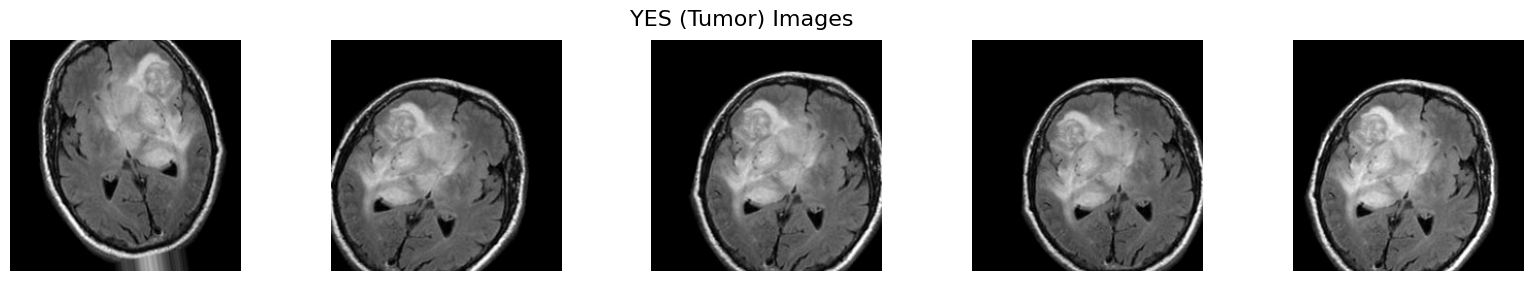

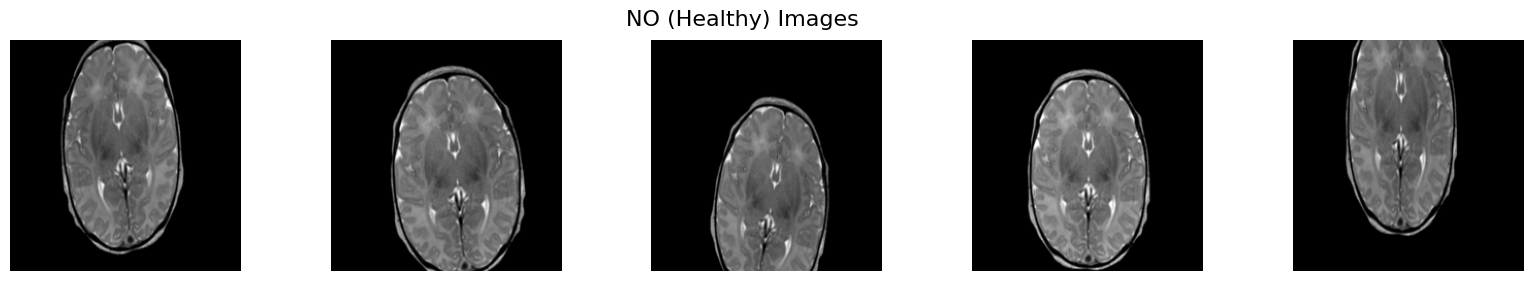

In [ ]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Dossiers finaux
final_yes = "/content/data_final/yes"
final_no = "/content/data_final/no"

# Liste des fichiers images
yes_files = [os.path.join(final_yes, f) for f in os.listdir(final_yes) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
no_files = [os.path.join(final_no, f) for f in os.listdir(final_no) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Fonction pour afficher les images
def display_images(filepaths, title, num_images=5, img_size=(224, 224)):
    plt.figure(figsize=(20, 3))
    plt.suptitle(title, fontsize=16)

    for i in range(num_images):
        img_path = random.choice(filepaths)
        img = Image.open(img_path).resize(img_size)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

#échantillons
display_images(yes_files, 'YES (Tumor) Images', num_images=5, img_size=(224, 224))
display_images(no_files, 'NO (Healthy) Images', num_images=5, img_size=(224, 224))


In [ ]:
# Fonction pour charger les chemins des fichiers et leurs labels
def load_data(paths, label):
    filepaths = []
    labels = []
    for path in paths:
        for file in os.listdir(path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepaths.append(os.path.join(path, file))
                labels.append(label)
    return filepaths, labels

# Charger les données
yes_files, yes_labels = load_data([yes_dir], 1)   # 1 pour "YES / Tumeur"
no_files, no_labels   = load_data([no_dir], 0)    # 0 pour "NO / Healthy"
# Combiner les données
filepaths = yes_files + no_files
labels = yes_labels + no_labels
# Vérification
print(f"Nombre total d'images : {len(filepaths)}")
print(f"YES (Tumeur) : {sum(labels)}")
print(f"NO (Healthy) : {len(labels) - sum(labels)}")

Nombre total d'images : 8170
YES (Tumeur) : 4080
NO (Healthy) : 4090


In [ ]:
import os
import shutil
import random

# Dossiers source
source_yes = "/content/data_final/yes"
source_no  = "/content/data_final/no"

base_dir = "/content/drive/MyDrive/AI_Tumor/data_final_split"
os.makedirs(base_dir, exist_ok=True)
# Pour chaque ensemble
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(os.path.join(base_dir, split, 'yes'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'no'), exist_ok=True)
# Paramètres de split
train_ratio = 0.7
val_ratio   = 0.1
test_ratio  = 0.2
# Fonction pour copier les fichiers
def split_and_copy(source_dir, class_name):
    files = [f for f in os.listdir(source_dir)
             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(files)
    n = len(files)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)

    for i, f in enumerate(files):
        if i < n_train:
            dest = os.path.join(base_dir, 'train', class_name, f)
        elif i < n_train + n_val:
            dest = os.path.join(base_dir, 'val', class_name, f)
        else:
            dest = os.path.join(base_dir, 'test', class_name, f)
        shutil.copy2(os.path.join(source_dir, f), dest)
# Copier les images
split_and_copy(source_yes, 'yes')
split_and_copy(source_no, 'no')
print(" Images copiées et dossiers train/val/test créés.")
# Print counts
print("\n Nombre d'images par dossier et classe :")
for split in splits:
    yes_count = len(os.listdir(os.path.join(base_dir, split, 'yes')))
    no_count  = len(os.listdir(os.path.join(base_dir, split, 'no')))
    total = yes_count + no_count
    print(f"{split.upper()}: Total={total}, YES={yes_count}, NO={no_count}")

✅ Images copiées et dossiers train/val/test créés.

📊 Nombre d'images par dossier et classe :
TRAIN: Total=7433, YES=3705, NO=3728
VAL: Total=1559, YES=776, NO=783
TEST: Total=2956, YES=1482, NO=1474


In [4]:
import tensorflow as tf
import os
base_dir = "/content/drive/MyDrive/AI_Tumor/data_final_split"

# Paramètres
batch_size = 32
img_size = (224, 224)
train_dirs = base_dir+"/train"
val_dirs   = base_dir+"/val"
test_dirs  = base_dir+"/test"

# Fonction pour créer un dataset depuis un dossier
def create_tf_dataset(data_dir, batch_size=batch_size, img_size=img_size, shuffle=True):
    """
    Crée un tf.data.Dataset directement depuis un dossier avec sous-dossiers par classe.
    """
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',              # 0 = NO, 1 = YES
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle
    )

    # Normalisation [0,1]
    dataset = dataset.map(lambda x, y: (x / 255.0, y))

    dataset = dataset.cache().prefetch(tf.data.AUTOTUNE)
    return dataset

# Créer les datasets
train_dataset = create_tf_dataset(train_dirs)
val_dataset   = create_tf_dataset(val_dirs, shuffle=False)
test_dataset  = create_tf_dataset(test_dirs, shuffle=False)

print(" Datasets prêts pour l'entraînement, la validation et le test.")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Found 7433 files belonging to 2 classes.
Found 1559 files belonging to 2 classes.
Found 2956 files belonging to 2 classes.
✅ Datasets prêts pour l'entraînement, la validation et le test.


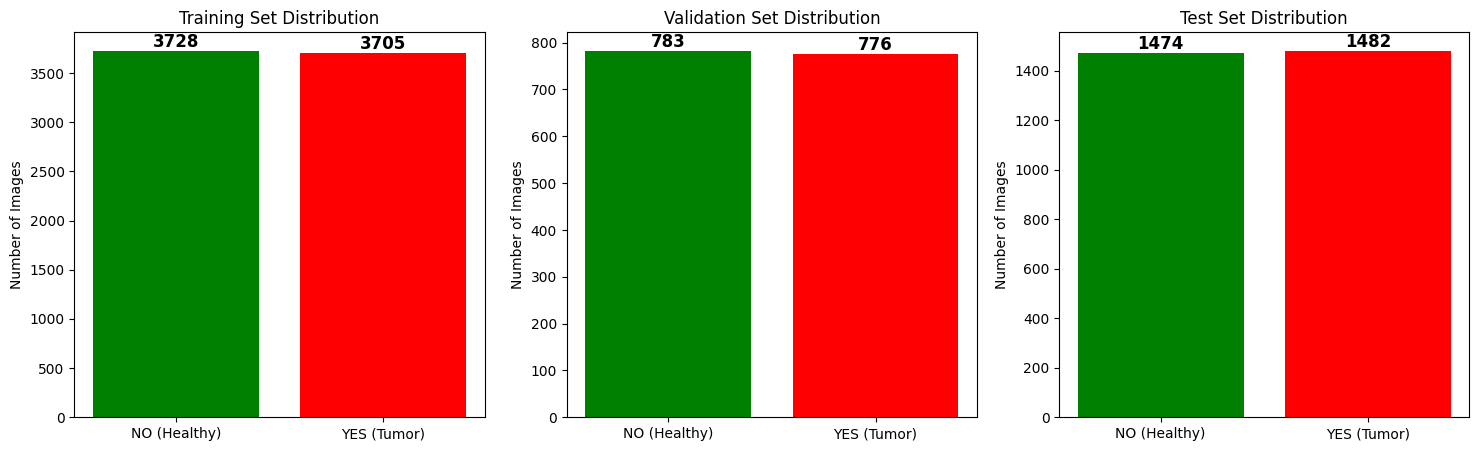

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Fonctions pour compter les images dans chaque classe
def count_images(split):
    split_dir = os.path.join(base_dir, split)
    yes_dir = os.path.join(split_dir, "yes")
    no_dir  = os.path.join(split_dir, "no")
    yes_count = len([f for f in os.listdir(yes_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    no_count  = len([f for f in os.listdir(no_dir)  if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return no_count, yes_count  # NO = 0, YES = 1

# Compter les images
train_counts = count_images("train")
val_counts   = count_images("val")
test_counts  = count_images("test")

# Définir les noms des classes
class_names = ["NO (Healthy)", "YES (Tumor)"]

# Création de l'histogramme
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Training set
bars_train = ax[0].bar(class_names, train_counts, color=['green', 'red'])
ax[0].set_title("Training Set Distribution")
ax[0].set_ylabel("Number of Images")
for bar in bars_train:
    ax[0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
               ha='center', va='bottom', fontsize=12, fontweight='bold')

# Validation set
bars_val = ax[1].bar(class_names, val_counts, color=['green', 'red'])
ax[1].set_title("Validation Set Distribution")
ax[1].set_ylabel("Number of Images")
for bar in bars_val:
    ax[1].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
               ha='center', va='bottom', fontsize=12, fontweight='bold')

# Test set
bars_test = ax[2].bar(class_names, test_counts, color=['green', 'red'])
ax[2].set_title("Test Set Distribution")
ax[2].set_ylabel("Number of Images")
for bar in bars_test:
    ax[2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
               ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.show()

**TRANSFER LEARNING MOBILENETV2**

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9333 - auc: 0.9729 - loss: 0.1609 - precision: 0.9194 - recall: 0.9600
Epoch 1: val_loss improved from inf to 0.01152, saving model to /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_TL.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 174s 735ms/step - accuracy: 0.9335 - auc: 0.9730 - loss: 0.1605 - precision: 0.9196 - recall: 0.9601 - val_accuracy: 0.9955 - val_auc: 1.0000 - val_loss: 0.0115 - val_precision: 0.9961 - val_recall: 0.9948
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9922 - auc: 0.9998 - loss: 0.0193 - precision: 0.9931 - recall: 0.9913
Epoch 2: val_loss improved from 0.01152 to 0.00930, saving model to /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_TL.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 158s 680ms/step - accuracy: 0.9922 - auc: 0.9998 - loss: 0.0193 - precision: 0.9931 - recall: 0.9913 - val_accuracy: 0.9955 - val_auc: 1.0000 - val_loss: 0.0093 - val_precision: 0.9987 - val_recall:

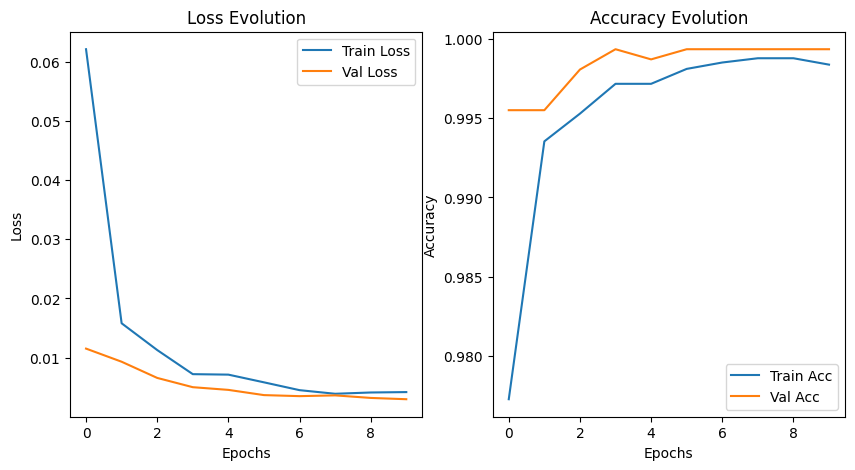


✅ Meilleur modèle sauvegardé ici : /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_TL.keras


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Charger le modèle pré-entraîné (MobileNetV2)
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
# On gèle toutes les couches pour le transfer learning pur
for layer in base_model.layers:
    layer.trainable = False

# Ajouter une tête de classification personnalisée
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # binaire : 0 ou 1

model = Model(inputs=base_model.input, outputs=output)

# Compilation du modèle
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

model.summary()

# Callbacks : EarlyStopping + sauvegarde du modèle
checkpoint_path = "/content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_TL.keras"

checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Entraînement (Transfer Learning)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[checkpoint, early_stop]
)

# Visualisation des performances
plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
print(f"\n Meilleur modèle sauvegardé ici : {checkpoint_path}")


**Charger le modèle et une image test aléatoire**


✅ Modèle chargé avec succès : /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_TL.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🧠 Prédiction du modèle : 1.0000 → Classe prédite = Yes (Tumeur)


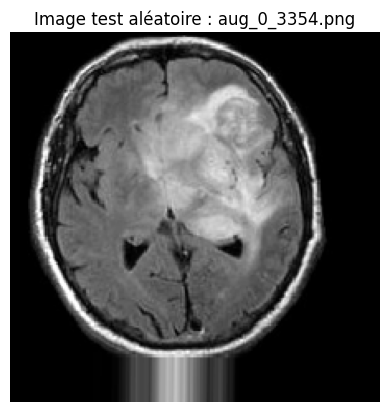

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing import image

# --- Charger le modèle MobileNetV2 déjà entraîné ---
model_path = "/content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_TL.keras"
model = tf.keras.models.load_model(model_path)
print("✅ Modèle chargé avec succès :", model_path)

test_dir = "/content/drive/MyDrive/AI_Tumor/data_final_split/test/yes"  # à adapter selon ton organisation

# --- Choisir une image aléatoire ---
img_name = random.choice(os.listdir(test_dir))
img_path = os.path.join(test_dir, img_name)

# --- Charger et prétraiter l’image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

# --- Prédiction du modèle ---
pred = model.predict(img_batch)[0][0]
print(f" Prédiction du modèle : {pred:.4f} → Classe prédite = {'Yes (Tumeur)' if pred > 0.5 else 'No (Sain)'}")

plt.imshow(img)
plt.axis('off')
plt.title(f"Image test aléatoire : {img_name}")
plt.show()


**XAI : Grad-CAM**

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


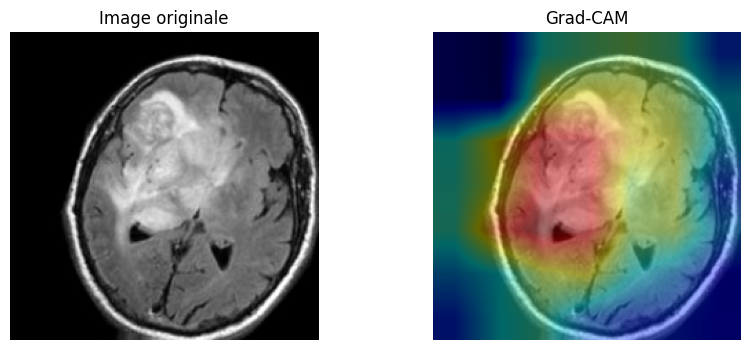

In [ ]:
# --- Grad-CAM ---
import tensorflow as tf
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# --- Générer la heatmap ---
last_conv_layer_name = "Conv_1"  # Dernière couche conv de MobileNetV2
heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)

# --- Superposer la heatmap sur l’image originale ---
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (224, 224))
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title("Image originale")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


**FINETUNING MOBILENETV2**

✅ Checkpoints seront sauvegardés ici : /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_finetuned.keras
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,914,369 (11.12 MB)

 Trainable params: 1,388,865 (5.30 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

Epoch 1/13
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9267 - auc: 0.9686 - loss: 0.2215 - precision: 0.9346 - recall: 0.9192
Epoch 1: val_loss improved from inf to 0.25390, saving model to /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_finetuned.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 992s 4s/step - accuracy: 0.9269 - auc: 0.9687 - loss: 0.2210 - precision: 0.9347 - recall: 0.9194 - val_accuracy: 0.9513 - val_auc: 0.9999 - val_loss: 0.2539 - val_precision: 1.0000 - val_recall: 0.9021
Epoch 2/13
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9920 - auc: 0.9997 - loss: 0.0260 - precision: 0.9916 - recall: 0.9927
Epoch 2: val_loss improved from 0.25390 to 0.14065, saving model to /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_finetuned.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.9920 - auc: 0.9997 - loss: 0.0260 - precision: 0.9916 - recall: 0.9927 - val_accuracy: 0.9872 - val_auc: 1.0000 - val_loss: 0.1407 - val_precision: 1.0000 - val_recal

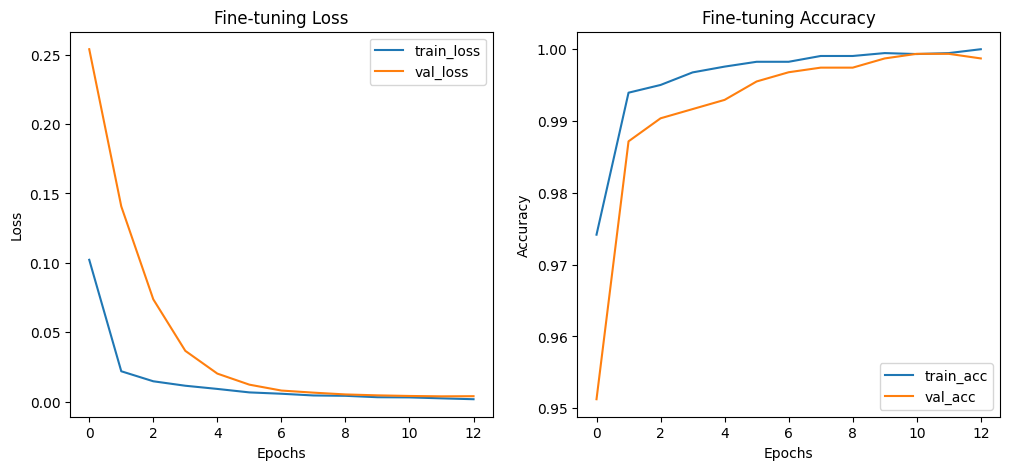

✅ Meilleur modèle sauvegardé ici : /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_finetuned.keras


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Chemin de sauvegarde des checkpoints
save_dir = "/content/drive/MyDrive/AI_Tumor"
model_path = os.path.join(save_dir, "best_model_MobileNetV2_finetuned.keras")
print(f" Checkpoints seront sauvegardés ici : {model_path}")

# Charger le modèle pré-entraîné et ajouter tête
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning : geler toutes les couches sauf les 10 dernières
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)
model.summary()

# Callbacks : EarlyStopping + ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=13,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Visualisation
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_fine.history['loss'], label='train_loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.title('Fine-tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_fine.history['accuracy'], label='train_acc')
plt.plot(history_fine.history['val_accuracy'], label='val_acc')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"✅ Meilleur modèle sauvegardé ici : {model_path}")

**Charger le modèle et une image test aléatoire**


✅ Modèle chargé avec succès : /content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_finetuned.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
🧠 Prédiction du modèle : 1.0000 → Classe prédite = Yes (Tumeur)


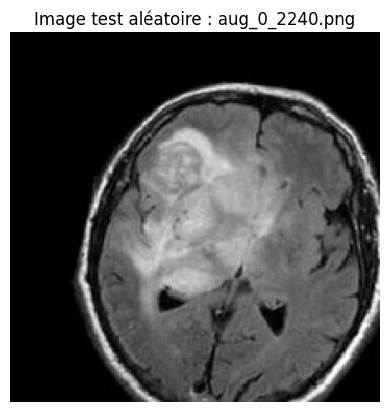

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing import image

model_path = "/content/drive/MyDrive/AI_Tumor/best_model_MobileNetV2_finetuned.keras"
model = tf.keras.models.load_model(model_path)
print("✅ Modèle chargé avec succès :", model_path)

test_dir = "/content/drive/MyDrive/AI_Tumor/data_final_split/test/yes"

# --- Choisir une image aléatoire dans ce dossier ---
img_name = random.choice(os.listdir(test_dir))
img_path = os.path.join(test_dir, img_name)

# --- Charger et prétraiter l’image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_array, axis=0)

# --- Prédiction du modèle ---
pred = model.predict(img_batch)[0][0]
print(f" Prédiction du modèle : {pred:.4f} → Classe prédite = {'Yes (Tumeur)' if pred > 0.5 else 'No (Sain)'}")

plt.imshow(img)
plt.axis('off')
plt.title(f"Image test aléatoire : {img_name}")
plt.show()


**XAI : Grad-CAM**

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


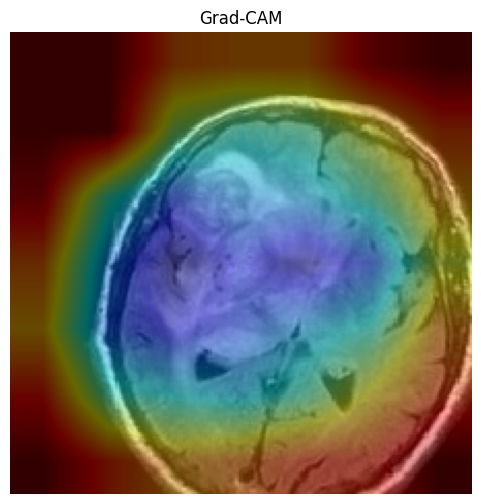

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Préparer l'image
if isinstance(img, np.ndarray):
    img_input = np.expand_dims(img, axis=0).astype("float32")
elif 'PIL.Image' in str(type(img)):
    img_input = np.expand_dims(np.array(img), axis=0).astype("float32")
else:
    img_input = tf.expand_dims(img, axis=0)

# Normalisation MobileNetV2
img_input = tf.keras.applications.mobilenet_v2.preprocess_input(img_input)

# Fonction Grad-CAM
def grad_cam(model, img_array, last_conv_layer_name="Conv_1"):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    # Modèle pour extraire les activations de la dernière couche conv + sortie
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Grad-CAM
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Redimensionner
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superposition
    original_img = img_array[0]
    original_img = ((original_img + 1.0) * 127.5).astype("uint8")
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    return superimposed_img

# Générer Grad-CAM
gradcam_img = grad_cam(model, img_input)
plt.figure(figsize=(6,6))
plt.imshow(gradcam_img)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()

**XAI : LIME**

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

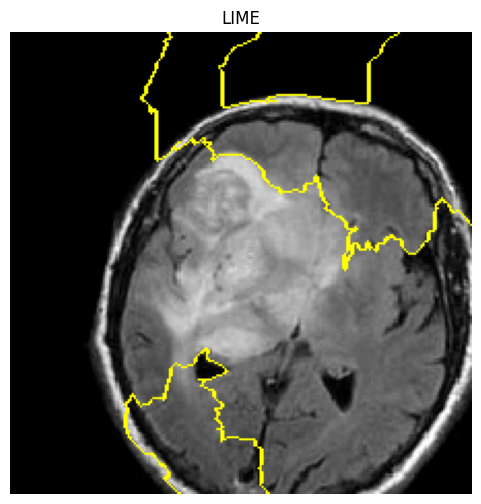

In [11]:
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import tensorflow as tf

# Préparer l'image pour LIME
if img_input.shape[0] == 1:
    img_example = img_input[0]

img_example_uint8 = ((img_example + 1.0) * 127.5).astype('uint8')

# explainer LIME
explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    images = tf.keras.applications.mobilenet_v2.preprocess_input(images.astype('float32'))
    return model.predict(images)

# Expliquer l'image
explanation = explainer.explain_instance(
    img_example_uint8,
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# image + masque
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME")
plt.axis('off')
plt.show()

**XAI : SHAP**

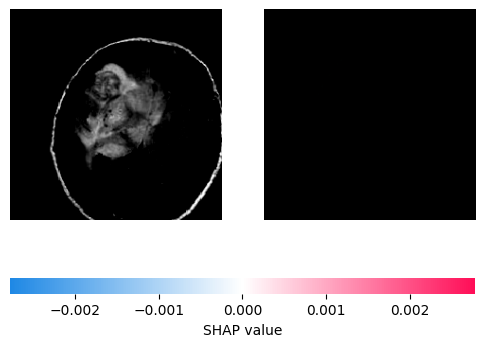

In [14]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Préparer l'image à expliquer
img_array = np.array(img).astype('float32')
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Préparer 10 images du batch
background = img_batch[:10].astype('float32')
background = preprocess_input(background)

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(img_array)

shap.image_plot(shap_values, img_array)